In [9]:
import torch
from math import sqrt
from simple_fem import get_cantilever

## Define the cantilever problem

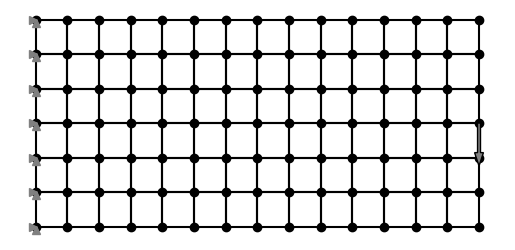

In [10]:
import matplotlib.pyplot as plt

cantilever = get_cantilever(1.0, 15.0, 7.0)
cantilever.plot()


## Optimization with MMA

In [11]:
def bisection(f, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c


def optimize_mma(fem, d_0, d_min, d_max, V_0, iter=15, s=0.7):
    d = [d_0]
    L = []
    a = fem.areas()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(d_min, a) > V_0 * torch.inner(d_max, a):
        raise Exception("x_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        # Solve the problem at point x_k
        u_k, f_k = fem.solve(d[k])

        # Get strain energy of all elements for the given displacement
        w_k = fem.element_strain_energies(u_k)

        # Compute lower asymptote
        if k <= 1:
            L_k = d[k] - s * (d_max - d_min)
        else:
            L_k = torch.zeros_like(L[k - 1])
            for j in range(len(L_k)):
                if (d[k][j] - d[k - 1][j]) * (d[k - 1][j] - d[k - 2][j]) < 0.0:
                    L_k[j] = d[k][j] - s * (d[k - 1][j] - L[k - 1][j])
                else:
                    L_k[j] = d[k][j] - 1 / sqrt(s) * (d[k - 1][j] - L[k - 1][j])
        L.append(L_k)

        # Compute lower move limit in this step
        d_min_k = torch.maximum(d_min, 0.9 * L[k] + 0.1 * d[k])

        # Analytical solution
        def d_star(mu):
            EPS = 1e-15
            d_hat = L[k] + torch.sqrt(
                (2 * w_k * (L[k] - d[k]) ** 2 + EPS) / (mu * a + EPS)
            )
            return torch.maximum(torch.minimum(d_hat, d_max), d_min_k)

        # Analytical gradient
        def grad(mu):
            return torch.dot(d_star(mu), a) - V_0 * torch.dot(d_max, a)

        # Solve dual problem
        mu_star = bisection(grad, 0.0, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        # Compute current optimal point with dual solution
        d.append(d_star(mu_star))

    return d


Iteration k=0 - Compliance: 0.41546
Iteration k=1 - Compliance: 0.73032
Iteration k=2 - Compliance: 0.60504
Iteration k=3 - Compliance: 0.60021
Iteration k=4 - Compliance: 0.59653
Iteration k=5 - Compliance: 0.59444
Iteration k=6 - Compliance: 0.59382
Iteration k=7 - Compliance: 0.59366
Iteration k=8 - Compliance: 0.59360
Iteration k=9 - Compliance: 0.59358
Iteration k=10 - Compliance: 0.59357
Iteration k=11 - Compliance: 0.59357
Iteration k=12 - Compliance: 0.59357
Iteration k=13 - Compliance: 0.59357
Iteration k=14 - Compliance: 0.59357


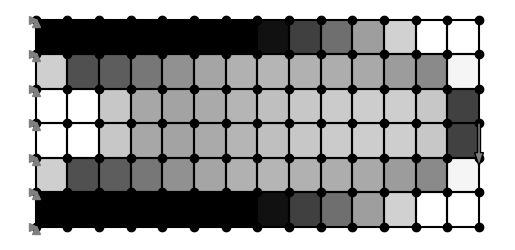

In [12]:
d_0 = torch.ones(cantilever.elements.shape[0])
d_min = 0.1 * torch.ones_like(d_0)
d_max = 1.0 * torch.ones_like(d_0)
V0 = 0.5

d_opt = optimize_mma(cantilever, d_0, d_min, d_max, V0)
cantilever.plot(element_property=d_opt[-1])
plt.savefig("figures/cantilever_fem_optimized.pdf", transparent=True, bbox_inches="tight")

## Optimization with optimality conditions

In [13]:
def optimize_oc(fem, d_0, d_min, d_max, V_0, iter=15, xi=0.5, m=0.5, p=1):
    d = [d_0]
    areas = fem.areas()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(d_min, areas) > V_0 * torch.inner(d_max, areas):
        raise Exception("x_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        u_k, f_k = fem.solve(d[k])
        w_k = fem.element_strain_energies(u_k)

        def make_step(mu):
            d_k = d[k].clone()
            G_k = p*d_k**(p-1) * w_k / (mu * areas)
            upper = torch.min(d_max, (1 + m) * d_k)
            lower = torch.max(d_min, (1 - m) * d_k)
            d_trial = G_k**xi * d_k
            return torch.maximum(torch.minimum(d_trial, upper), lower)

        def g(mu):
            d_k = make_step(mu)
            return torch.dot(d_k, areas) - V_0 * torch.dot(d_max, areas)

        mu = bisection(g, 0.00001, 0.2, tol=1e-15)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        d.append(make_step(mu))

    return d

Iteration k=0 - Compliance: 0.41546
Iteration k=1 - Compliance: 0.83091
Iteration k=2 - Compliance: 0.66287
Iteration k=3 - Compliance: 0.60395
Iteration k=4 - Compliance: 0.59620
Iteration k=5 - Compliance: 0.59460
Iteration k=6 - Compliance: 0.59408
Iteration k=7 - Compliance: 0.59385
Iteration k=8 - Compliance: 0.59373
Iteration k=9 - Compliance: 0.59367
Iteration k=10 - Compliance: 0.59363
Iteration k=11 - Compliance: 0.59360
Iteration k=12 - Compliance: 0.59359
Iteration k=13 - Compliance: 0.59358
Iteration k=14 - Compliance: 0.59357


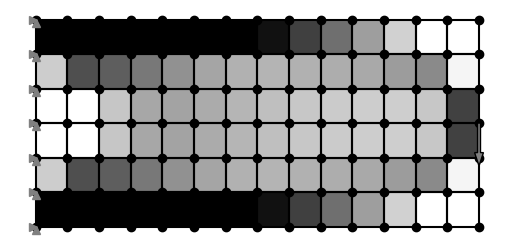

In [14]:
d_opt = optimize_oc(cantilever, d_0, d_min, d_max, V0)
cantilever.plot(element_property=d_opt[-1])

## Optimizing a larger structure

Iteration k=0 - Compliance: 0.35912
Iteration k=1 - Compliance: 0.71825
Iteration k=2 - Compliance: 0.57274
Iteration k=3 - Compliance: 0.51913
Iteration k=4 - Compliance: 0.51305
Iteration k=5 - Compliance: 0.51160
Iteration k=6 - Compliance: 0.51098
Iteration k=7 - Compliance: 0.51064
Iteration k=8 - Compliance: 0.51043
Iteration k=9 - Compliance: 0.51027
Iteration k=10 - Compliance: 0.51017
Iteration k=11 - Compliance: 0.51009
Iteration k=12 - Compliance: 0.51003
Iteration k=13 - Compliance: 0.50999
Iteration k=14 - Compliance: 0.50995
Iteration k=15 - Compliance: 0.50993
Iteration k=16 - Compliance: 0.50990
Iteration k=17 - Compliance: 0.50988
Iteration k=18 - Compliance: 0.50986
Iteration k=19 - Compliance: 0.50985
Iteration k=20 - Compliance: 0.50984
Iteration k=21 - Compliance: 0.50983
Iteration k=22 - Compliance: 0.50982
Iteration k=23 - Compliance: 0.50981
Iteration k=24 - Compliance: 0.50980


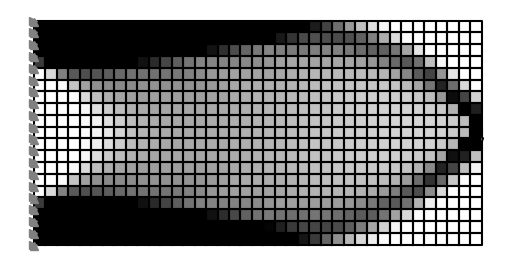

In [15]:
large_cantilever = get_cantilever(1.0, 40.0, 20.0)

d_0 = torch.ones(large_cantilever.elements.shape[0])
d_min = 0.1 * torch.ones_like(d_0)
d_max = 1.0 * torch.ones_like(d_0)
V0 = 0.5
d_opt = optimize_oc(large_cantilever, d_0, d_min, d_max, V0, p=1, iter=30)
large_cantilever.plot(element_property=d_opt[-1])

## SIMP approach for binarization

Iteration k=0 - Compliance: 0.35912
Iteration k=1 - Compliance: 0.71825
Iteration k=2 - Compliance: 0.57274
Iteration k=3 - Compliance: 0.52614
Iteration k=4 - Compliance: 0.52328
Iteration k=5 - Compliance: 0.52251
Iteration k=6 - Compliance: 0.52276
Iteration k=7 - Compliance: 0.52399
Iteration k=8 - Compliance: 0.52660
Iteration k=9 - Compliance: 0.52971
Iteration k=10 - Compliance: 0.53086
Iteration k=11 - Compliance: 0.53176
Iteration k=12 - Compliance: 0.53279
Iteration k=13 - Compliance: 0.53391
Iteration k=14 - Compliance: 0.53545
Iteration k=15 - Compliance: 0.53728
Iteration k=16 - Compliance: 0.53862
Iteration k=17 - Compliance: 0.53989
Iteration k=18 - Compliance: 0.54099
Iteration k=19 - Compliance: 0.54149
Iteration k=20 - Compliance: 0.54160
Iteration k=21 - Compliance: 0.54171
Iteration k=22 - Compliance: 0.54191
Iteration k=23 - Compliance: 0.54206
Iteration k=24 - Compliance: 0.54217
Iteration k=25 - Compliance: 0.54241
Iteration k=26 - Compliance: 0.54270
Iteration k

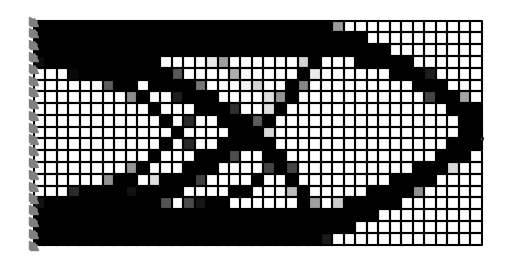

In [17]:
d_opt = optimize_oc(large_cantilever, d_0, d_min, d_max, V0, p=2, iter=30)
large_cantilever.plot(element_property=d_opt[-1])